In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.datasets import load_digits
import torch

from raytracerthing import RayTracerThing, Activations

np.random.seed(42)

In [2]:
digits = load_digits()
digits.keys()

y = digits['target']

X = digits['images']
X = X[y < 2]
X = X / X.max()
N = X.shape[0]
image_shape = X.shape[1:]

print(N, image_shape)

y = y[y < 2]

print(y[:5])

360 (8, 8)
[0 1 0 1 0]


In [3]:
np.unique(y, return_counts=True)

(array([0, 1]), array([178, 182]))

In [4]:
layer_shape = image_shape

clf = RayTracerThing(input_shape=image_shape,
                     hidden_layer_shape=layer_shape, n_layers=2,
                     activation_func=torch.sigmoid)

In [5]:
def log_loss(true_label, predicted_prob):
    if true_label == 1:
        return -torch.log(predicted_prob)
    else:
        return -torch.log(1 - predicted_prob)
    
#     return torch.where(torch.tensor(true_label) == 1, -torch.log(predicted_prob), -torch.log(1 - predicted_prob))

In [6]:
from time import time

start = time()

def reset(tensor):
    tensor.detach_()
    tensor.requires_grad_(True)
    tensor.retain_grad()

    if tensor.grad is not None:
        tensor.grad.detach_()
        tensor.grad.zero_() 

eta = 0.1
n_epochs = 1000

# early stopping stuff
best_loss = float('inf')
n_epochs_no_improvement = 0
patience = 20

for epoch in range(n_epochs):
    epoch_loss = torch.zeros(N)
    epoch_grads = torch.zeros(N, clf.n_layers, *clf.layer_shape)

    image_i = 0
    
    for image, label in zip(X, y):    
        out = clf.forward(image)        
        loss = log_loss(label, out)

        loss.backward()

        for i in range(clf.n_layers):        
#             clf.W[i] = clf.W[i] - eta * clf.W[i].grad
            epoch_grads[image_i][i] = clf.W[i].grad.clone()

            reset(clf.W[i])
            
        epoch_loss[image_i] = loss       
        image_i += 1
                
    with torch.no_grad():
        mean_grad = epoch_grads.mean(dim=0)
        
        for i in range(clf.n_layers):
            clf.W[i] = clf.W[i] - eta * mean_grad[i]
            clf.W[i] = torch.clamp(clf.W[i], 0.0001, 0.9999)
            
            reset(clf.W[i])
            
    mean_loss = torch.mean(loss)
        
    print('Epoch %d of %d - Loss: %.4f' % (epoch + 1, n_epochs, mean_loss), end='\r')
    
    if mean_loss <= best_loss:
        best_loss = mean_loss
        n_epochs_no_improvement = 0
    else:
        n_epochs_no_improvement += 1

        if n_epochs_no_improvement > patience:           
            print('\nStopping early.')
            break
        
print()

elapsed = time() - start

minutes = elapsed // 60
seconds = elapsed % 60

print('Elapsed time (wall): %02dm %02ds' % (minutes, seconds))

Epoch 1000 of 1000 - Loss: 0.7133
Elapsed time (wall): 00m 50s


In [7]:
outputs = []

with torch.no_grad():
    for i, image in enumerate(X):
        print('\rImage %d of %d' % (i + 1, N), end='')
        outputs.append(clf.forward(image))

print()

Image 360 of 360


In [8]:
def accuracy(y, y_hat, threshold=0.5):
    y_hat = np.array(list(map(lambda x: 0 if x < threshold else 1, y_hat)))
    
    return 1 - np.abs(y - y_hat).mean()

In [9]:
thetas = np.linspace(0, 1, 21)
accuracy_scores = [accuracy(y, outputs, threshold=theta) for theta in thetas]

Text(0,0.5,'Accuracy')

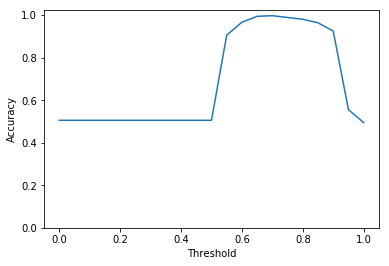

In [10]:
import matplotlib.pyplot as plt
 
plt.plot(thetas, accuracy_scores)
plt.ylim(0)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')

In [11]:
threshold = thetas[np.argmax(accuracy_scores)]
threshold

0.7000000000000001

In [12]:
np.max(accuracy_scores)

0.9972222222222222

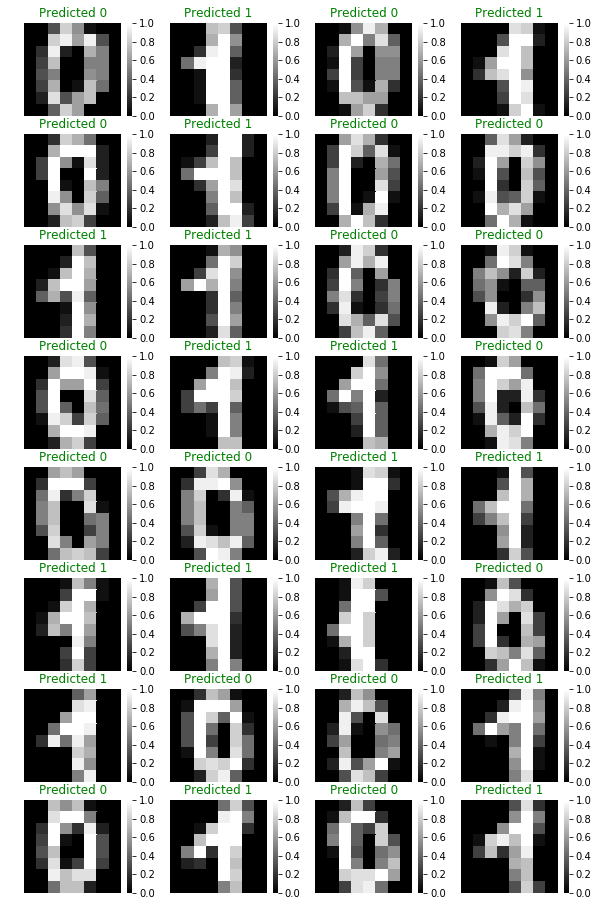

In [13]:
n_rows = 8
n_cols = 4
n_total = n_rows * n_cols
n_total = min(n_total, N)

width_ratio = 2.7
height_ratio = 2

figsize = (int(width_ratio * n_cols), int(height_ratio * n_rows))

fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
axes = axes.ravel()

for ax, image, expected, actual in zip(axes, X[:n_total], y[:n_total], outputs[:n_total]):
    sns.heatmap(image, vmin=0.0, vmax=1.0, cmap='gray', ax=ax)
    ax.set_axis_off()

    actual = 0 if actual < threshold else 1

    color = 'green' if expected == actual else 'red'
    ax.set_title('Predicted %d' % actual, color=color)

plt.show()